# Idea

The goal here is to create a model to account only for the last two observed weeks of data. The reason to do this is to refine the prophet model, which does a very good job in finding the trends and seasonal components.

The reason I believe this model will work is because the baseline model, which used the last observation from 14 days behind the observed date to make the estimation, did a decent job.

In [198]:
from storeSalesUtils.dataloading import load_stores, load_train, load_holidays, load_test, load_oil
from storeSalesUtils.plotting import plot_joint_plot
from storeSalesUtils.prophetPipeline import RMSLE, grangers_causation_matrix

import pandas as pd
from pandas.errors import SettingWithCopyWarning
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

from tqdm.auto import tqdm

import warnings
warnings.simplefilter("ignore", SettingWithCopyWarning)
warnings.simplefilter("ignore", FutureWarning)

plt.rcParams["figure.figsize"] = (16, 4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pilot model for one store only

## Import modeling libraries

In [199]:
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

## Useful functions

In [200]:
def make_shifted(df, shift_col, minlag, maxlag):
    new_df = df.copy()
    for i in range(minlag, maxlag+1):
        new_df.loc[:, '%s_%i'%(shift_col, i)] = new_df[shift_col].shift(i)
        
    return new_df

def backshift_df(df, shift_vars, minlag, maxlag, num_cols):
    df = df.set_index('date').resample('d').first()
    
    for var in shift_vars:
        df = make_shifted(df, var, minlag, maxlag)
    
    return df

def add_date_features(df, date_col):
    # Date Features
    new_df = df.copy()
    new_df['year'] = new_df[date_col].dt.year
    new_df['month'] = new_df[date_col].dt.month
    new_df['day'] = new_df[date_col].dt.day
    new_df['dayofyear'] = new_df[date_col].dt.dayofyear
    new_df['dayofweek'] = new_df[date_col].dt.dayofweek
    new_df['weekofyear'] = new_df[date_col].dt.weekofyear
    new_df['is_weekend'] = np.where(new_df.dayofweek.isin([5, 6]), 1, 0)
    
    return new_df

def make_model_df(df, group_col, backshift_cols, minlag, maxlag, category_cols, num_cols):
    new_df = df.groupby(group_col, as_index=False).apply(lambda x: backshift_df(x, backshift_cols, minlag, maxlag, num_cols)).reset_index()
    new_df.drop('level_0', 1, inplace=True)
    new_df = add_date_features(new_df, 'date')
    
    if category_cols:
        for col in category_cols:
            new_df[col] = new_df[col].astype('category')
        
    return new_df

## Training and validation setup

In [224]:
train = load_train()
stores = load_stores()
holidays = load_holidays()
oil = load_oil()

# I will make one model by family here
# family = 'SCHOOL AND OFFICE SUPPLIES' # hardest category for prophetModel
# store_nbr = 47
# family = 'AUTOMOTIVE' # feature selector chooses only one feature
# store_nbr = 24
# family = 'AUTOMOTIVE' 
# store_nbr = 42
family = 'BABY CARE' # no features selected for this with alpha=1
store_nbr = 1

# train = train[train.family==family]
train = train[(train.family==family) & (train.store_nbr==store_nbr)]
train = pd.merge(train, stores, on='store_nbr')

# only use two years of data available
maxDate = train.date.max()
minDate = maxDate - pd.DateOffset(years=2)
print('Using data within the dates: ', minDate, maxDate)
train = train[train.date.between(minDate, maxDate)]

# simulate test set scenario using the last 15 days of data for validation
val_dates = maxDate - pd.DateOffset(15)
train['split'] = np.where(train.date>=val_dates, 'validation', 'train')

train['ly_sales'] = train.groupby('store_nbr').sales.transform(lambda x: x.shift(52*7))

# when we predict the future, no information is available
# I need to do this to set up the proper autorregresive values
train_missingSales = train.copy()
train_missingSales.loc[train.split=='validation', 'sales'] = np.nan

print(train_missingSales.shape)
train_missingSales.head()

Using data within the dates:  2015-08-15 00:00:00 2017-08-15 00:00:00
(730, 12)


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,split,ly_sales
954,1700029,2015-08-15,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,train,NaN
955,1701811,2015-08-16,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,train,NaN
956,1703593,2015-08-17,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,train,NaN
957,1705375,2015-08-18,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,train,NaN
958,1707157,2015-08-19,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,train,NaN


Okay, so the first thing here is to add the autorregressive components from the last two weeks of data. We will do this by store:

In [225]:
category_cols = None
group_col = 'store_nbr'
backshift_cols = ['sales', 'ly_sales']
ar_maxlags = 7
ar_minlags = 1
num_cols = ['onpromotion']

train_df = make_model_df(train_missingSales, group_col, backshift_cols, ar_minlags, ar_maxlags, category_cols, num_cols)
train_df = train_df.fillna(method='bfill')

print(train_df.shape)
train_df.head()

(732, 33)


,date,id,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,ly_sales_5,ly_sales_6,ly_sales_7,year,month,day,dayofyear,dayofweek,weekofyear,is_weekend
0,2015-08-15,1700029.0,1.0,BABY CARE,0.0,0.0,Quito,Pichincha,D,13.0,...,0.0,0.0,0.0,2015,8,15,227,5,33,1
1,2015-08-16,1701811.0,1.0,BABY CARE,0.0,0.0,Quito,Pichincha,D,13.0,...,0.0,0.0,0.0,2015,8,16,228,6,33,1
2,2015-08-17,1703593.0,1.0,BABY CARE,0.0,0.0,Quito,Pichincha,D,13.0,...,0.0,0.0,0.0,2015,8,17,229,0,34,0
3,2015-08-18,1705375.0,1.0,BABY CARE,0.0,0.0,Quito,Pichincha,D,13.0,...,0.0,0.0,0.0,2015,8,18,230,1,34,0
4,2015-08-19,1707157.0,1.0,BABY CARE,0.0,0.0,Quito,Pichincha,D,13.0,...,0.0,0.0,0.0,2015,8,19,231,2,34,0


In [226]:
train_df[train_df.store_nbr==store_nbr][['date', 'sales', 'ly_sales', 'sales_1', 'sales_7', 'ly_sales_1', 'ly_sales_7']]

,date,sales,ly_sales,sales_1,sales_7,ly_sales_1,ly_sales_7
0,2015-08-15,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-08-16,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-08-17,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-08-18,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-08-19,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
727,2017-08-11,NaN,0.0,NaN,NaN,0.0,0.0
728,2017-08-12,NaN,0.0,NaN,NaN,0.0,0.0
729,2017-08-13,NaN,0.0,NaN,NaN,0.0,0.0
730,2017-08-14,NaN,0.0,NaN,NaN,0.0,0.0


In [227]:
train_df[train_df.store_nbr==store_nbr][['date', 'sales', 'ly_sales', 'sales_1', 'sales_7', 'ly_sales_1', 'ly_sales_7']].tail(50)

,date,sales,ly_sales,sales_1,sales_7,ly_sales_1,ly_sales_7
682,2017-06-27,0.0,0.0,0.0,0.0,0.0,0.0
683,2017-06-28,0.0,0.0,0.0,0.0,0.0,0.0
684,2017-06-29,0.0,0.0,0.0,0.0,0.0,0.0
685,2017-06-30,0.0,0.0,0.0,0.0,0.0,0.0
686,2017-07-01,0.0,0.0,0.0,0.0,0.0,0.0
687,2017-07-02,0.0,0.0,0.0,0.0,0.0,0.0
688,2017-07-03,0.0,0.0,0.0,0.0,0.0,0.0
689,2017-07-04,0.0,0.0,0.0,0.0,0.0,0.0
690,2017-07-05,0.0,0.0,0.0,0.0,0.0,0.0
691,2017-07-06,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot: >

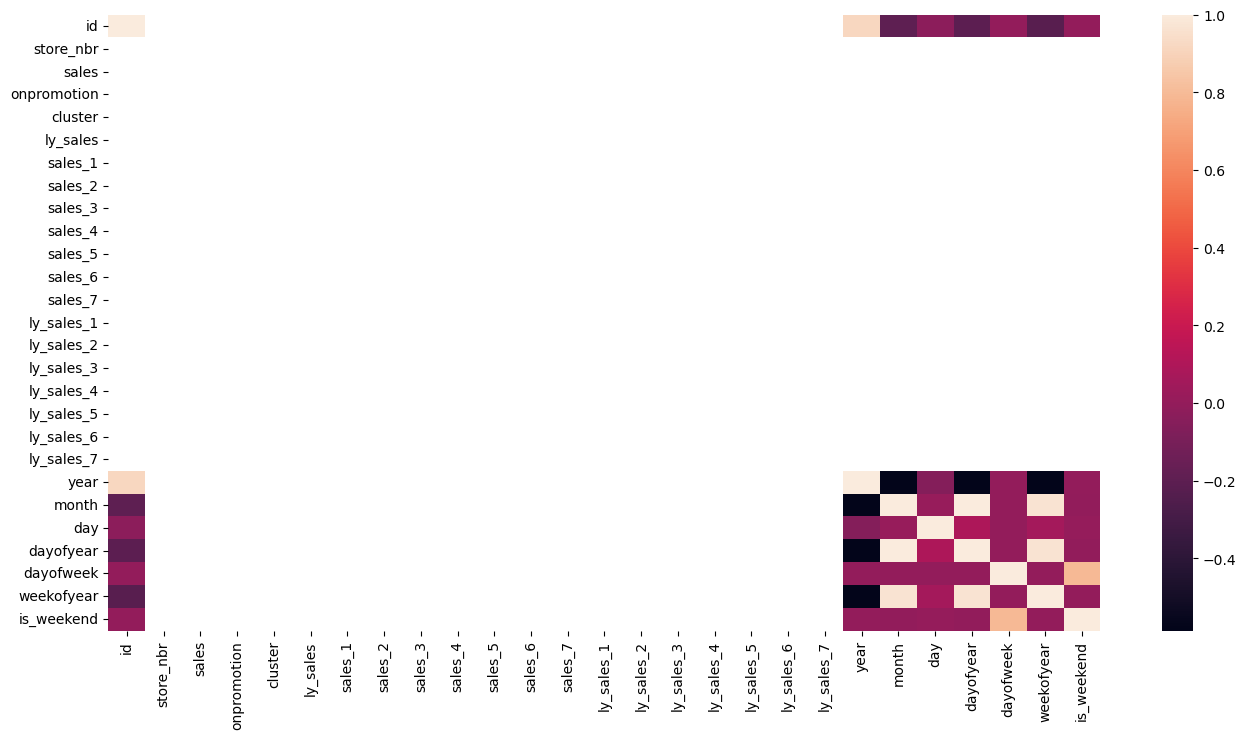

In [228]:
plt.figure(figsize=(16, 8))
sns.heatmap(train_df.corr())

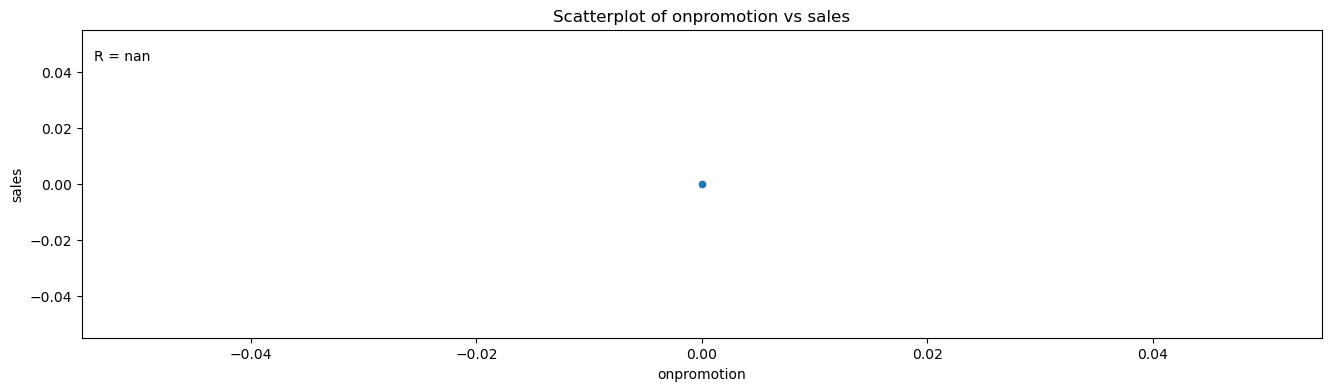

In [229]:
ax = sns.scatterplot(train, x='onpromotion', y='sales')
plt.title('Scatterplot of onpromotion vs sales')
plt.text(0.01, 0.9, 'R = %.03f' %train.loc[:,['onpromotion','sales']].corr().iloc[0,1], transform=ax.transAxes)
plt.show()

<AxesSubplot: title={'center': 'sales'}, xlabel='is_weekend'>

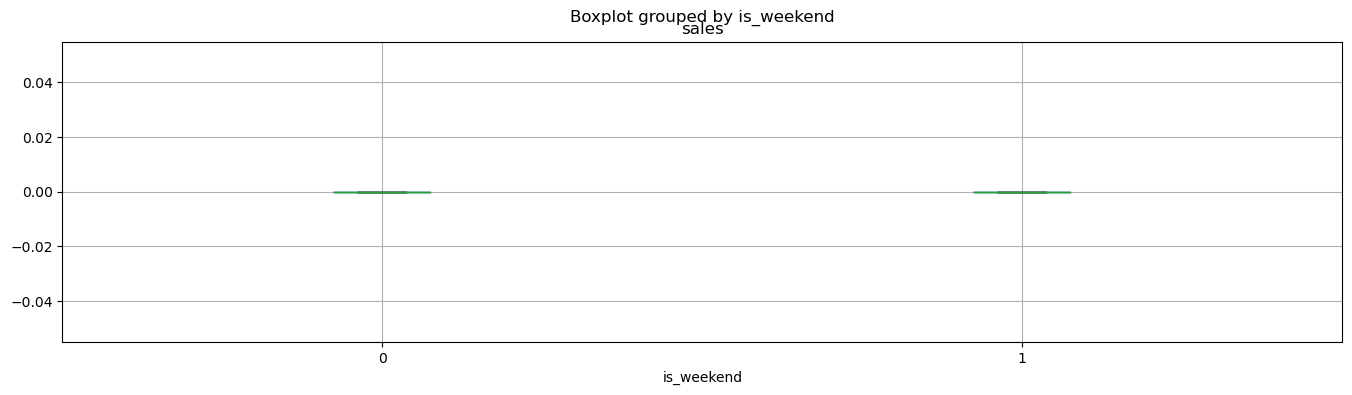

In [230]:
train_df.boxplot(column='sales', by='is_weekend')

In [235]:
dep_var = 'sales'
y_train = train_df[train_df.split=='train'][dep_var]
drop_cols = [dep_var, 'family', 'city', 'state', 'type', 'split', 'date', 'id', 'store_nbr']
X_train = train_df[train_df.split=='train'].drop(drop_cols, 1)

lasso = Lasso(alpha=1).fit(X_train.fillna(method='ffill').fillna(method='bfill'), y_train)
selector = SelectFromModel(lasso, prefit=True)
if sum(selector.get_support())>0:
    X_train = X_train[X_train.columns[selector.get_support()]]
else:
    pass

print('Number of training features: ', X_train.shape[1])
model = xgb.XGBRegressor(tree_method="hist", enable_categorical=True, n_jobs=4)

model.fit(X_train, y_train)

/home/jeronimo/miniconda3/envs/jero/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Number of training features:  24


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

<AxesSubplot: >

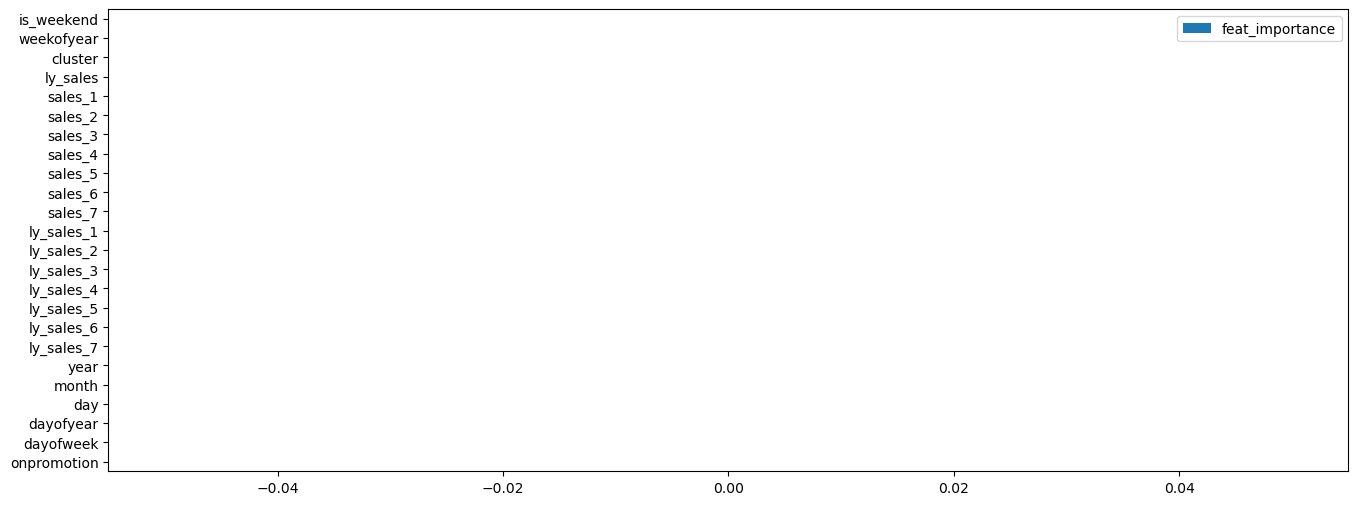

In [236]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['feat_importance'])
feature_importances.sort_values('feat_importance').plot.barh(figsize=(16, 6))

In [239]:
y_val = train_df[train_df.split=='validation'][dep_var]
X_val = train_df[train_df.split=='validation'].drop(drop_cols, 1)
# X_val = X_val[X_val.columns[selector.get_support()]]

In [240]:
# Compute Prediction
valid_pred = model.predict(X_val)

# Actual Validation vs. Prediction
df_valid = train[train.split=='validation']
df_valid['prediction'] = valid_pred
df_valid['prediction'] = df_valid.prediction.map(lambda x: max(0, x))

df_valid.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,split,ly_sales,prediction
1668,2972377,2017-07-31,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,validation,0.0,1.716818e-16
1669,2974159,2017-08-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,validation,0.0,1.716818e-16
1670,2975941,2017-08-02,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,validation,0.0,1.716818e-16
1671,2977723,2017-08-03,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,validation,0.0,1.716818e-16
1672,2979505,2017-08-04,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,validation,0.0,1.716818e-16


In [241]:
stores[stores.store_nbr==store_nbr]

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13


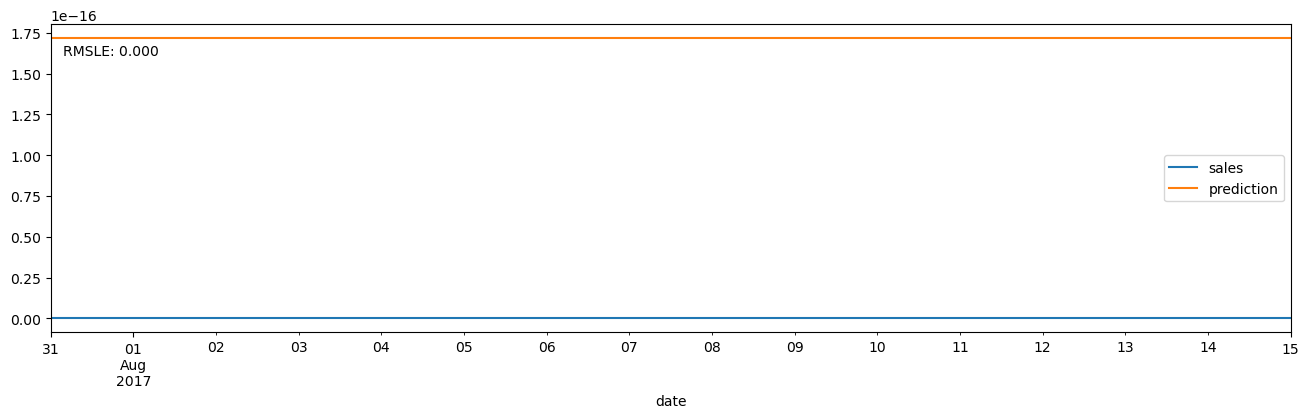

In [245]:
ax = df_valid.set_index('date').plot(y=['sales', 'prediction'])
plt.text(0.01, 0.9, "RMSLE: %.03f" %RMSLE(_store_df.sales, _store_df.prediction), transform=ax.transAxes)
plt.show()

In [243]:
df_valid.groupby('store_nbr').apply(lambda x: RMSLE(x[dep_var], x.prediction)).sort_values(ascending=False)

store_nbr
1    0.0
dtype: float64

# Test set

In [105]:
test = load_test()
test = test[test.family==family]
test = pd.merge(test, stores, on='store_nbr')

test.head()

,id,date,store_nbr,family,onpromotion,city,state,type,cluster
0,3000919,2017-08-16,1,SCHOOL AND OFFICE SUPPLIES,14,Quito,Pichincha,D,13
1,3002701,2017-08-17,1,SCHOOL AND OFFICE SUPPLIES,0,Quito,Pichincha,D,13
2,3004483,2017-08-18,1,SCHOOL AND OFFICE SUPPLIES,0,Quito,Pichincha,D,13
3,3006265,2017-08-19,1,SCHOOL AND OFFICE SUPPLIES,0,Quito,Pichincha,D,13
4,3008047,2017-08-20,1,SCHOOL AND OFFICE SUPPLIES,0,Quito,Pichincha,D,13


We train the model with the most recent information

In [109]:
model_df = make_model_df(train, group_col, backshift_cols, ar_minlags, ar_maxlags, category_cols, num_cols)

y = model_df[dep_var]
X = model_df.drop(drop_cols, 1)
X = X[X_val.columns]

model = xgb.XGBRegressor(tree_method="hist", enable_categorical=True, n_jobs=4)

model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [111]:
model_test = pd.concat([train, test])
model_test['ly_sales'] = model_test.groupby('store_nbr').sales.transform(lambda x: x.shift(52*7))

model_test = make_model_df(model_test, group_col, backshift_cols, ar_minlags, ar_maxlags, category_cols, num_cols)

model_test['pred'] = model.predict(model_test[X_val.columns])
model_test['pred'] = model_test.pred.map(lambda x: max(0, x))

print(model_test.shape)
model_test.head()

(1596, 34)


,date,id,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,ly_sales_6,ly_sales_7,year,month,day,dayofyear,dayofweek,weekofyear,is_weekend,pred
0,2017-08-16,3000919.0,1.0,SCHOOL AND OFFICE SUPPLIES,NaN,14.0,Quito,Pichincha,D,13.0,...,NaN,NaN,2017,8,16,228,2,33,0,128.267212
1,2017-08-17,3002701.0,1.0,SCHOOL AND OFFICE SUPPLIES,NaN,0.0,Quito,Pichincha,D,13.0,...,NaN,NaN,2017,8,17,229,3,33,0,54.089508
2,2017-08-18,3004483.0,1.0,SCHOOL AND OFFICE SUPPLIES,NaN,0.0,Quito,Pichincha,D,13.0,...,NaN,NaN,2017,8,18,230,4,33,0,54.811314
3,2017-08-19,3006265.0,1.0,SCHOOL AND OFFICE SUPPLIES,NaN,0.0,Quito,Pichincha,D,13.0,...,NaN,NaN,2017,8,19,231,5,33,1,72.551254
4,2017-08-20,3008047.0,1.0,SCHOOL AND OFFICE SUPPLIES,NaN,0.0,Quito,Pichincha,D,13.0,...,NaN,NaN,2017,8,20,232,6,33,1,75.082626


<AxesSubplot: xlabel='date'>

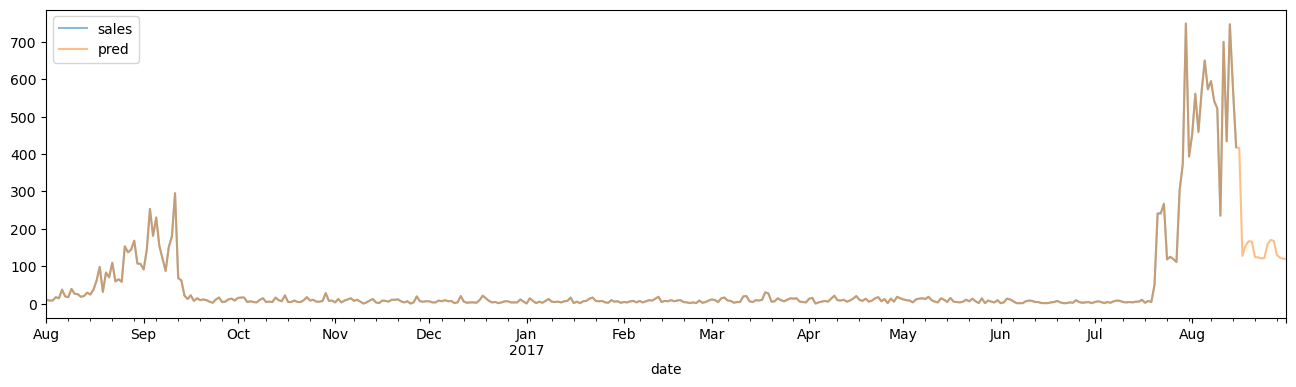

In [113]:
_model_test = model_test[model_test.store_nbr==store_nbr].set_index('date')

_model_test[_model_test.index>='2016-08-01'].plot(y=['sales', 'pred'], alpha=0.5)